# Inverse-Model
Implementation steps
- [x] Implement hessian-vector product
- [x] implement projected newton solver
- [x] ensure correctness with measurement times not conforming to grid
- [ ] verify functioning model with linear interpolation of boundary concentrations
- [ ] extend to full 3d brain with proper data
- [ ] performance optimization by caching
- [ ] run full model for all subjects
- [ ] enable linear interpolation measurements

In [1]:
import numpy as np
import dolfin as df
import tqdm
from dolfin import inner, grad, dot

from glymphopt.datageneration import BoundaryConcentration
from glymphopt.finite_differences import gradient_finite_differences, hessian_finite_differences
from glymphopt.io import read_mesh, read_function_data
from glymphopt.measure import measure
from glymphopt.minimize import projected_newton_solver
from glymphopt.operators import (
    mass_matrix, boundary_mass_matrix, stiffness_matrix, matrix_operator, bilinear_operator, matmul, zero_vector
)
from glymphopt.parameters import parameters_2d_default
from glymphopt.timestepper import TimeStepper

[garrus:70650] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.garrus.1000/jf.0/2705784832/shared_mem_cuda_pool.garrus could be created.
[garrus:70650] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [2]:
def vector2coeff(x: np.ndarray, *args):
    return parameters_2d_default() | {key: xi for key, xi in zip(args, x)}

def coeff2vector(coefficients: dict[str, float], *args):
    return np.array([coefficients[key] for key in args])

class Model:
    def __init__(self, V, D=None, g=None):
        D = D or df.Identity(2)
        
        domain = V.mesh()
        dx = df.Measure("dx", domain)
        ds = df.Measure("ds", domain)
        
        u, v = df.TrialFunction(V), df.TestFunction(V)
        self.M = df.assemble(inner(u, v) * dx)
        self.DK = df.assemble(inner(D * grad(u), grad(v)) * dx)
        self.S = df.assemble(inner(u, v) * ds)
        self.g = g or BoundaryConcentration(V)


def gradient_sensitivities(F, x, **kwargs):
    return np.array([F(x, ei, **kwargs) for ei in np.eye(len(x))])

def measure_interval(n: int, td: np.ndarray, timestepper: TimeStepper):
    bins = np.digitize(td, timestepper.vector(), right=True)
    return list(np.where(n == bins)[0])

class InverseProblem:
    def __init__(self, data_path, dt=0.1, progress=True):
        self.progress = progress
        domain = read_mesh(data_path)
        self.td, self.Yd = read_function_data(data_path, domain, "concentration")
        t_start = self.td[0]
        N = int(np.ceil(np.round((self.td[-1] - t_start) / dt, 12)))
        t_end = N * dt
        self.timestepper = TimeStepper(dt, (t_start, t_end))
        self.V = self.Yd[0].function_space()
        self.model = Model(self.V, g=BoundaryConcentration(self.V))
        
    def F(self, x):
        Y = self.forward(x)
        Ym = measure(self.timestepper, Y, self.td)
        _M_ = bilinear_operator(self.model.M)
        J = 0.5 * sum([
            _M_(Ym_i.vector() - Yd_i.vector(), Ym_i.vector() - Yd_i.vector()) 
            for Ym_i, Yd_i in zip(Ym, self.Yd)
        ])
        return J
    
    def gradF(self, x):
        dt = self.timestepper.dt
        model = self.model
        Y = self.forward(x)
        Ym = measure(self.timestepper, Y, self.td)
        P = self.adjoint(x, self.timestepper, Ym)
        G = [matmul(model.S, model.g(t)) for t in self.timestepper.vector()]
        _M_ = bilinear_operator(model.M)
        _DK_ = bilinear_operator(model.DK)
        _S_ = bilinear_operator(model.S)
        return dt * sum(
            np.array([
                _DK_(p.vector(), y.vector()),
                _M_(p.vector(), y.vector()),
                _S_(p.vector(), y.vector()) - p.vector().inner(g),
            ])
            for y, p, g in zip(Y[1:], P[:-1], G[1:])
        )

    def dF(self, x, dx):
        timestepper = self.timestepper
        coefficients = vector2coeff(x)
        Y = self.forward(x)
        dY = self.sensitivity(x, dx, Y)
        
        Ym = measure(self.timestepper, Y, self.td)
        dYm = measure(timestepper, dY, self.td)
        _M_ = bilinear_operator(self.model.M)
        return sum([_M_(ym.vector() - yd.vector(), dy.vector()) for ym, yd, dy in zip(Ym, self.Yd, dYm)])
    
    def hess(self, x):
        return np.array([
            self.hessp(x, ei) for ei in np.eye(len(x))
        ])
    
    def hessp(self, x, dx):
        dt = self.timestepper.dt
        Y = self.forward(x)
        Ym = measure(self.timestepper, Y, self.td)
        dY = self.sensitivity(x, dx, Y)
        dYm = measure(self.timestepper, dY, self.td)
        
        P = self.adjoint(x, self.timestepper, Ym)
        dP = self.second_order_adjoint(x, dx, dYm, P)
        
        model = self.model
        G = [matmul(model.S, model.g(t)) for t in self.timestepper.vector()]
        _DK_ = bilinear_operator(model.DK)
        _M_ = bilinear_operator(model.M)
        _S_ = bilinear_operator(model.S)
        return dt * sum(
            np.array([
                _DK_(dp.vector(), y.vector()) + _DK_(p.vector(), dy.vector()),
                _M_(dp.vector(), y.vector()) + _M_(p.vector(), dy.vector()),
                _S_(dp.vector(), y.vector()) - dp.vector().inner(g) + _S_(p.vector(), dy.vector()),
            ])
            for y, dy, p, dp, g in zip(Y[1:], dY[1:], P[:-1], dP[:-1], G[1:])
        )

    def forward(self, x):
        coefficients = vector2coeff(x, "a", "r", "k")
        a = coefficients["a"]
        r = coefficients["r"]
        k = coefficients["k"]
        
        timestepper = self.timestepper
        dt = timestepper.dt
        timepoints = timestepper.vector()
        Y = [
            df.Function(self.V, name="state") 
            for _ in range(len(timepoints))
        ]
        Y[0].assign(self.Yd[0])
        model = self.model
        M = model.M
        L = a * model.DK + r * model.M + k * model.S
        solver = df.LUSolver(M + dt * L)
        Mdot = matrix_operator(M)
        G = [matmul(model.S, model.g(t)) for t in timepoints]
        for n in range(self.timestepper.num_intervals()):
            solver.solve(Y[n+1].vector(), Mdot(Y[n].vector()) + dt * k * G[n+1])
        return Y
    
    def adjoint(self, x, timestepper, Ym) -> list[df.Function]:
        # TODO: Needs speedup. Should not allocate zero_vector at each iteration.
        coefficients = vector2coeff(x, "a", "r", "k")
        a = coefficients["a"]
        r = coefficients["r"]
        k = coefficients["k"]
        
        
        dt = timestepper.dt
        timepoints = timestepper.vector()
        
        model = self.model
        M = model.M
        L = a * model.DK + r * model.M + k * model.S
        solver = df.LUSolver(M + dt * L)

        P = [
            df.Function(self.V, name="adjoint") 
            for _ in range(len(timepoints))
        ]
        Mdot = matrix_operator(M)
        num_intervals = timestepper.num_intervals()
        for n in range(num_intervals, 0, -1):
            nj = measure_interval(n, self.td, self.timestepper)
            jump = sum((matmul(M, (Ym[j].vector() - Yd[j].vector())) for j in nj))#, start=zero_vector(self.V))

            solver.solve(
                P[n-1].vector(),
                Mdot(P[n].vector()) - jump,
            )
        return P
    
    def sensitivity(self, x, dx, Y) -> list[df.Function]:
        coefficients = vector2coeff(x, "a", "r", "k")
        a = coefficients["a"]
        r = coefficients["r"]
        k = coefficients["k"]
        dD, dr, dk = dx

        timestepper = self.timestepper
        dt = timestepper.dt
        timepoints = timestepper.vector()
        dY = [df.Function(self.V, name="sensitivity") for _ in range(len(timepoints))]

        model = self.model
        M = model.M
        L = a * model.DK + r * model.M + k * model.S
        solver = df.LUSolver(M + dt * L)
        
        dL = dD * model.DK + dr * model.M + dk * model.S
        Mdot = matrix_operator(M)
        dLdot = matrix_operator(dL)
        Sdot = matrix_operator(model.S)
        G = [matmul(model.S, model.g(t)) for t in timepoints]
        for n, t in enumerate(timepoints[1:], start=0):
            solver.solve(
                dY[n+1].vector(),
                Mdot(dY[n].vector()) - dt * dLdot(Y[n+1].vector()) + dt * dk * G[n+1]
            )
        return dY
    
    def second_order_adjoint(self, x, dx, dYm, P):
        coefficients = vector2coeff(x, "a", "r", "k")
        a = coefficients["a"]
        r = coefficients["r"]
        k = coefficients["k"]
        dD, dr, dk = dx

        timestepper = self.timestepper
        dt = timestepper.dt
        timepoints = timestepper.vector()
        
        dP = [df.Function(self.V, name="second-order-adjoint") for _ in range(len(timepoints))]

        model = self.model
        M = model.M
        L = a * model.DK + r * model.M + k * model.S
        dL = dD * model.DK + dr * model.M + dk * model.S
        solver = df.LUSolver(M + dt * L)

        Mdot = matrix_operator(M)
        dLdot = matrix_operator(dL)
        num_intervals = timestepper.num_intervals()
        for n in range(num_intervals, 0, -1):
            nj = measure_interval(n, self.td, self.timestepper)
            jump = sum((matmul(M, dYm[j].vector()) for j in nj))
            solver.solve(
                dP[n - 1].vector(),
                Mdot(dP[n].vector()) - dt * dLdot(P[n-1].vector()) - jump,
            )
        return dP


In [3]:
data_path = "../resources/concentrations.hdf"
progress = True
domain = read_mesh(data_path)
td, Yd = read_function_data(data_path, domain, "concentration")

coefficients = parameters_2d_default()
x0 = coeff2vector(coefficients, "a", "r", "k")
x1 = 0.9 * x0
problem = InverseProblem(data_path, dt=0.1)
problem.F(x0)

2.4536373442562422e-23

# Convergence test for gradient

In [4]:
dF_findiff = gradient_finite_differences(problem.F, x1, h=1e-5)

In [5]:
gradF = problem.gradF(x1)

h = 0.1, errornorm = 3.8878763693139233, rel=
h = 0.05, errornorm = 0.9657156496509575, rel=4.0259017969928665
h = 0.025, errornorm = 0.24104080816602313, rel=4.006440473705164
h = 0.0125, errornorm = 0.06023598672215362, rel=4.001608030061091
h = 0.00625, errornorm = 0.015057489989072382, rel=4.000400250364999
h = 0.003125, errornorm = 0.0037642778337268943, rel=4.000100591449816
h = 0.0015625, errornorm = 0.000941086916560361, rel=3.9999257958926844
h = 0.00078125, errornorm = 0.00023526658516708008, rel=4.000087457774873


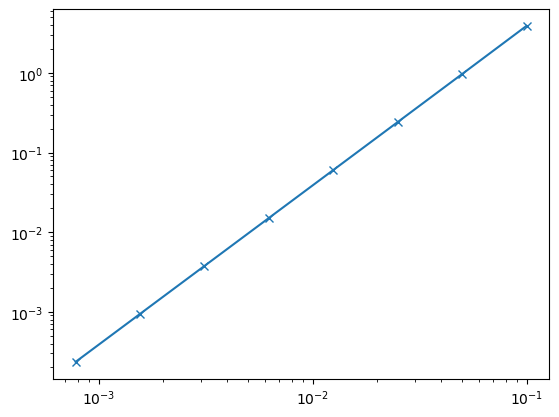

In [6]:
import matplotlib.pyplot as plt
x = x1
gradF = problem.gradF(x)

hs = [0.5**i * 1e-1 for i in range(8)]
errors = np.nan * np.zeros_like(hs)
for i, h in enumerate(hs):
    dF_findiff = gradient_finite_differences(problem.F, x, h=h)
    errors[i] = np.linalg.norm(gradF - dF_findiff)
    if i > 0:
        print(f"h = {h}, errornorm = {errors[i]}, rel={errors[i-1]/errors[i]}")
    else:
        print(f"h = {h}, errornorm = {errors[i]}, rel=")

plt.loglog(hs, errors, "x-")
plt.show()

# Hessians

In [7]:
H = problem.hess(x)
H

array([[ 1.26393643e+01, -3.67711810e+03,  2.76653349e+01],
       [-3.67711810e+03,  3.71265944e+06, -1.64234000e+04],
       [ 2.76653349e+01, -1.64234000e+04,  5.33873384e+02]])

In [8]:
H_fd = hessian_finite_differences(problem.F, x, h=1e-4)
H_fd

array([[ 1.26393797e+01, -3.67717476e+03,  2.76653333e+01],
       [-3.67717476e+03,  3.71270639e+06, -1.64235323e+04],
       [ 2.76653333e+01, -1.64235323e+04,  5.33873368e+02]])

In [9]:
H - H_fd

array([[-1.53646089e-05,  5.66579664e-02,  1.63032501e-06],
       [ 5.66579664e-02, -4.69536512e+01,  1.32269097e-01],
       [ 1.63032503e-06,  1.32269096e-01,  1.53989218e-05]])

In [12]:
import time as pytime
import scipy.optimize
bounds = scipy.optimize.Bounds([1e-1, 0, 0], [np.inf, np.inf, np.inf])
tic = pytime.time()
sol_x = projected_newton_solver(
    problem.F,
    problem.gradF,
    problem.hessp,
    bounds=bounds,
    x0=x1
)
toc = pytime.time()
print(f"Run in {toc - tic}s")

Run in 45.812538623809814s


In [13]:
sol_x

  message: Convergence: Projected gradient norm below tolerance.
  success: True
      fun: 8.282807460641504e-25
        x: [ 1.010e+01  1.000e-03  1.310e+00]
      nit: 4
     nfev: 5
     njev: 5
     nhev: 16
      jac: [ 6.420e-13 -5.108e-10 -1.765e-11]
 walltime: 45.81241321563721